In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
class Panel:
    def __init__(self,xa,ya,xb,yb):
        self.xa,self.ya = xa,ya
        self.xb,self.yb = xb,yb
        self.xc,self.yc = (xa+xb)/2, (ya+yb)/2
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2)
        if xb-xa <= 0.:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
            
        self.n=[numpy.cos(self.beta),numpy.sin(self.beta)]
        self.t=[-numpy.sin(self.beta),numpy.cos(self.beta)]
        self.sigma = 1
        self.vt = 0
        self.cp = 0
        self.kappa = 1

In [3]:
N_panels = 20                    # number of panels desired

T = 0.12
H = 0.00
c = 1
a = c/4
r = (0.25+T/(3*numpy.sqrt(3)))                      # circle radius
zeta_c = -4*a/(3*numpy.sqrt(3))*T + 1j*2*a*H        # circle center
theta = numpy.linspace(0, 2*numpy.pi, N_panels+1)   # theta endpoints of panels
zeta = r*numpy.exp(1j*theta)                       # endpoints of circle surface panels
z_ends = (zeta+zeta_c) + a**2/(zeta+zeta_c)        # endpoints of airfoil surface panels
x_ends,  y_ends = z_ends.real, z_ends.imag

# define the panels
panels = numpy.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])

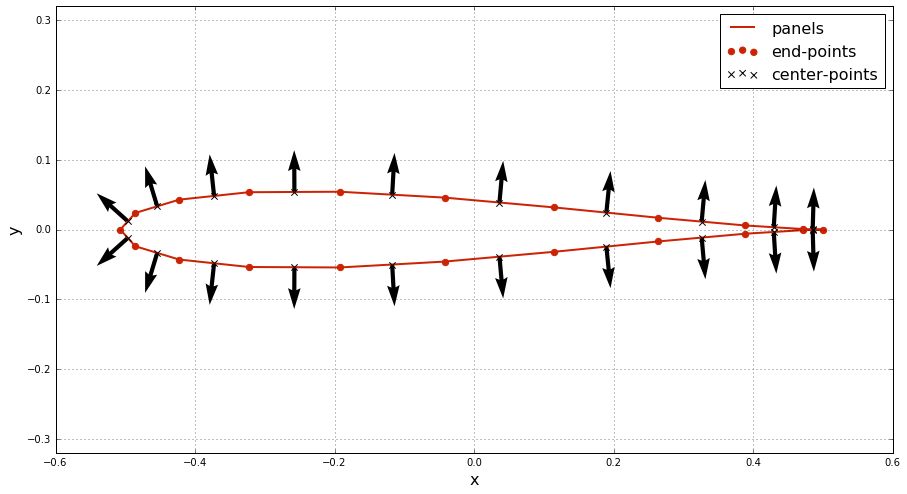

In [4]:
pyplot.figure(figsize=(15, 8))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_ends, y_ends, color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels], color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], color='k', marker='x', s=40, zorder=3)
pyplot.quiver([p.xc for p in panels], [p.yc for p in panels], [p.n[0] for p in panels], [p.n[1] for p in panels],
              scale=20, width=0.005)
pyplot.legend(['panels', 'end-points', 'center-points'], 
           loc='best', prop={'size':16})
pyplot.axis('equal');

In [5]:
class FS:
    def __init__(self,u_inf,alpha):
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)
        
u_inf = 1
alpha = 2.0
fs = FS(u_inf,alpha)

In [6]:
def panel_doub_vel(p,x,y): 
    x_p = numpy.sin(p.beta)*(x-p.xb) - numpy.cos(p.beta)*(y-p.yb)
    y_p = numpy.cos(p.beta)*(x-p.xb) + numpy.sin(p.beta)*(y-p.yb)
    
    u_p = -p.kappa/(2*numpy.pi)*( (y_p/(x_p**2+y_p**2)) - (y_p/((x_p-p.length)**2+y_p**2)) )
    v_p = p.kappa/(2*numpy.pi)*( (x_p/(x_p**2+y_p**2)) - ((x_p-p.length)/((x_p-p.length)**2+y_p**2)) )
    
    u = numpy.sin(p.beta)*u_p + numpy.cos(p.beta)*v_p
    v = -numpy.cos(p.beta)*u_p + numpy.sin(p.beta)*v_p
    return u,v

In [7]:
def panel_doub_vel_wake(p,x,y):
    x_p = numpy.sin(p.beta)*(x-p.xb) - numpy.cos(p.beta)*(y-p.yb)
    y_p = numpy.cos(p.beta)*(x-p.xb) + numpy.sin(p.beta)*(y-p.yb)
    u_p = -p.kappa/(2*numpy.pi)*(y_p/(x_p**2+y_p**2))
    v_p = p.kappa/(2*numpy.pi)*(x_p/(x_p**2+y_p**2))
    u = numpy.sin(p.beta)*u_p + numpy.cos(p.beta)*v_p
    v = -numpy.cos(p.beta)*u_p + numpy.sin(p.beta)*v_p
    return u,v

In [8]:
#normal comp
def build_matrix(panels):
    N=len(panels)
    A = numpy.empty((N,N),dtype=float)
    b = numpy.empty(len(panels),dtype=float)
    A[N-1,0]=1
    A[N-1,1:-2]=0
    A[N-1,-2:]=-1
    
    for i, p_i in enumerate(panels):
        for j,p_j in enumerate(panels):
            
            if i != j and i!=N-1 and j!=N-1:
                A[i,j] = numpy.dot(panel_doub_vel(p_j,p_i.xc,p_i.yc),p_i.n)
            elif i == j and i!=N-1 and j !=N-1:
                A[i,j] = 2/(numpy.pi*p_j.length)
            elif j == N-1 and i!=N-1:
                A[i,j]=numpy.dot(panel_doub_vel_wake(p_j,p_i.xc,p_i.yc),p_i.n)
        
        b[i:-1] = -numpy.dot(numpy.array([u_inf*numpy.cos(fs.alpha),u_inf*numpy.sin(fs.alpha)]),p_i.n)
        b[-1]=0
    return A,b

In [9]:
A,b = build_matrix(panels)
A,b

(array([[  2.19081295e+01,  -9.31885227e+00,  -9.18410984e-01,
          -2.89307093e-01,  -1.27550757e-01,  -6.62364939e-02,
          -3.73312153e-02,  -2.13692307e-02,  -1.11844804e-02,
          -3.56018063e-03,   3.32495190e-03,   1.09352374e-02,
           2.10882078e-02,   3.69906885e-02,   6.57843790e-02,
           1.26867226e-01,   2.88023731e-01,   9.14553678e-01,
           9.22085010e+00,  -1.09540648e+01],
        [ -1.58637023e+00,   7.69164792e+00,  -2.88671123e+00,
          -4.55394365e-01,  -1.67982098e-01,  -8.08246834e-02,
          -4.38311589e-02,  -2.46001124e-02,  -1.27951448e-02,
          -4.16963205e-03,   3.54157737e-03,   1.21115623e-02,
           2.37829797e-02,   4.27351882e-02,   7.91020323e-02,
           1.64499073e-01,   4.43803643e-01,   2.66786507e+00,
          -7.43724954e+00,  -2.25945373e+00],
        [ -1.83173178e-01,  -1.45868052e+00,   5.11201454e+00,
          -1.80602418e+00,  -3.20109404e-01,  -1.24160852e-01,
          -6.10627734e-02,

In [10]:
kappa = numpy.linalg.solve(A,b)
kappa

array([  93.25206791,   72.6695769 ,   67.33169103,   62.66250357,
         57.98390986,   53.23068345,   48.42971429,   43.58746035,
         38.66539913,   33.34709001,   26.5118227 ,   21.10189136,
         16.02363602,   10.98155516,    5.9661107 ,    1.01998503,
         -3.77577049,   -8.31603872,  -12.04804223,  105.30011015])

In [11]:
for i, panel in enumerate(panels):
    panel.kappa = kappa[i]

In [12]:
#tangential comp
def build_matrix2(panels):
    N=len(panels)
    A2 = numpy.empty((N,N),dtype=float)
    b2 = numpy.empty(len(panels),dtype=float)
    A2[N-1,0]=1
    A2[N-1,1:-2]=0
    A2[N-1,-2:]=-1
    
    for i, p_i in enumerate(panels):
        for j,p_j in enumerate(panels):
            
            if i != j and i!=N-1 and j!=N-1:
                A2[i,j] = numpy.dot(panel_doub_vel(p_j,p_i.xc,p_i.yc),p_i.t)
            elif i == j and i!=N-1 and j !=N-1 and i!=0 and j!=0 and i!=N-2 and j!=N-2:
                A[i,j] = -1/2*(panels[i+1].kappa-panels[i-1].kappa)/numpy.sqrt(\
                        (panels[i+1].xc-panels[i-1].xc)**2+(panels[i+1].xc-panels[i-1].xc)**2)
                
                #A2[i,j] = -1/2*([p_j.kappa for p_j in panels][i+1]-[p_j.kappa for p_j in panels][i-1])\
                #/numpy.sqrt(([p_i.xc for p_i in panels][i+1]-[p_i.xc for p_i in panels][i-1])**2+\
                            #([p_i.xc for p_i in panels][i+1]-[p_i.xc for p_i in panels][i-1])**2)
            elif i ==0 and j==0:
                A2[i,j] = A2[1,1]
            elif i ==N-2 and j==N-2:
                A2[i,j] = A2[-2,-2]
            elif j == N-1 and i!=N-1:
                A2[i,j]=numpy.dot(panel_doub_vel_wake(p_j,p_i.xc,p_i.yc),p_i.t)
        
        b2[i:-1] = -numpy.dot(numpy.array([u_inf*numpy.cos(fs.alpha),u_inf*numpy.sin(fs.alpha)]),p_i.t)
        b2[-1]=0
    return A2,b2

In [13]:
A2,b2 = build_matrix2(panels)

In [14]:
A2

array([[  1.13327394e-316,  -3.40105629e+000,   9.14808588e-001,
          5.77065619e-001,   3.91032937e-001,   2.85468831e-001,
          2.21084009e-001,   1.79547005e-001,   1.51489039e-001,
          1.30651716e-001,   1.09210122e-001,   9.63448896e-002,
          8.59845650e-002,   7.42238717e-002,   5.54568508e-002,
          1.47383106e-002,  -1.03145503e-001,  -6.38742923e-001,
         -1.30462571e+001,  -1.20792265e-013],
       [  2.92361553e+000,   1.13327394e-316,  -1.28419199e+000,
          3.11660253e-001,   2.78193729e-001,   2.29637702e-001,
          1.94331659e-001,   1.70057626e-001,   1.53633670e-001,
          1.41622249e-001,   1.26774441e-001,   1.20486443e-001,
          1.17169349e-001,   1.12447628e-001,   9.68802360e-002,
          3.19600590e-002,  -3.34354323e-001,  -7.31824906e+000,
          1.08818608e+001,  -3.30134274e+000],
       [  3.82331310e-001,   1.20557967e+000,               nan,
         -3.47157465e-001,   2.08938579e-001,   2.04017517e-0

In [15]:
for i, p_i in enumerate(panels):
    vt = numpy.array([0])
    for j, p_j in enumerate(panels):
        if i != j:
            vt = vt + A2[i,j]
    vt = vt + b2[i]
    p_i.vt = float(vt)
    p_i.cp = 1.0 - (p_i.vt/u_inf)**2

In [16]:
[p.cp for p in panels]

[-165.51577907566397,
 -20.5992293881664,
 -99.9270005531004,
 -169.0052590378869,
 -224.72949193494318,
 -284.1205209367102,
 -388.284235191802,
 -628.3420886943999,
 -1308.3299046193465,
 -2831.62868200657,
 -2633.8475556513285,
 -1131.1534814463942,
 -505.8570152739014,
 -294.3203383057199,
 -206.6395095431917,
 -160.36486467741014,
 -122.22323903123637,
 -84.92525938352959,
 -85.35634316488812,
 1.0]

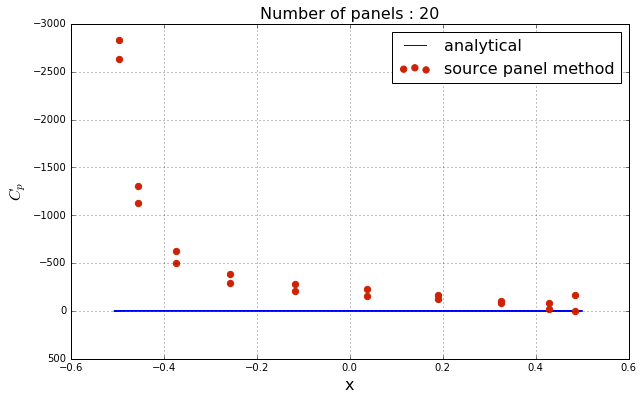

In [17]:
# create surface of airfoil for analytical solution
theta = numpy.linspace(0.01, 2*numpy.pi-0.01, 41)      # theta coordinates
zeta = r*numpy.exp(1j*theta)                  # circle coordinates
z = (zeta+zeta_c) + a**2/(zeta+zeta_c)        # airfoil coordinates

# flow parameters
al = 2.0*numpy.pi/180                          # angle of attack
kappaz = 2*numpy.pi*u_inf*r**2                   # doublet strength for circle with radius r
Gam = 4*numpy.pi*r*u_inf*numpy.sin(al+2*H)      # vortex strength

# compute the complex velocity on the surface
w = u_inf - kappaz/(2*numpy.pi)/zeta**2 + 1j*Gam/(2*numpy.pi)/zeta
zeta = zeta*numpy.exp(1j*al)

# Joukowski transformation
w = w/(1 - a**2/(zeta+zeta_c)**2)
cp_analytical = 1 - numpy.abs(w)**2/u_inf**2

# plots the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.gca().invert_yaxis()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot(z.real, cp_analytical, color='b', linestyle='-', linewidth=1, zorder=1)
pyplot.scatter([p.xc for p in panels], [p.cp for p in panels], color='#CD2305', s=40, zorder=2)
pyplot.title('Number of panels : %d' % N_panels, fontsize=16)
pyplot.legend(['analytical', 'source panel method'], loc='best', prop={'size':16});